In [1]:
import sys
# import from dirs below
sys.path.insert(0, "..")
sys.path.insert(0, "../src")
sys.path.insert(0, "../src/new_generation")

In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
from typing import List, Tuple
import random

from copy import deepcopy
import networkx as nx

import line_generation as lg
from Genotype import Genotype
from fitness import fitness
from params import N, SEED, N_IN_POPULATION
from graph_generation import generate_city_graph
from SimultionEngine import SimulationEngine

from main import create_initial_population, n_best_survive, new_generation_replace_random_line, run_simulation

from new_generation.Mutators import LineMutator, GenotypeMutator
from new_generation.SpecimenCrossers import GenotypeCrosser

In [9]:
from SimultionEngine import SimulationEngine

In [10]:
G, best_paths = generate_city_graph(N)

line_mutator = LineMutator(best_paths)
genotype_mutator = GenotypeMutator(G, best_paths)

genotype_crosser = GenotypeCrosser(best_paths)

## Symulacja

Population 0, fitness function: 237.1982728035756
lines with X stops: Counter({10: 200})


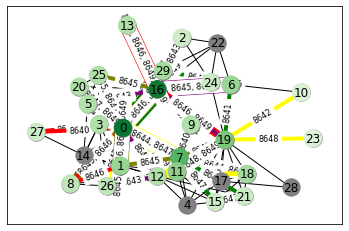

Population 100, fitness function: -12.0
lines with X stops: Counter({1: 170, 2: 28, 3: 2})


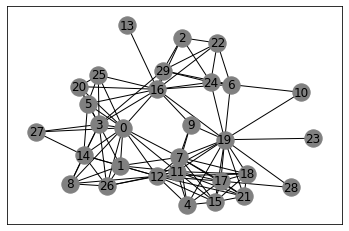

Population 200, fitness function: -12.0
lines with X stops: Counter({1: 172, 2: 25, 3: 2, 0: 1})


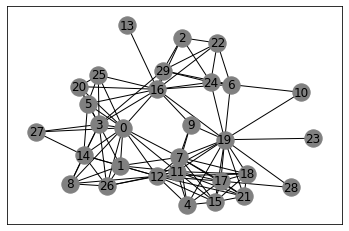

Population 300, fitness function: -12.0
lines with X stops: Counter({1: 175, 2: 25})


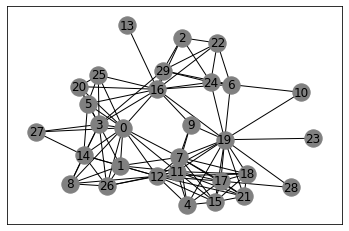

Population 400, fitness function: -12.0
lines with X stops: Counter({1: 163, 2: 36, 3: 1})


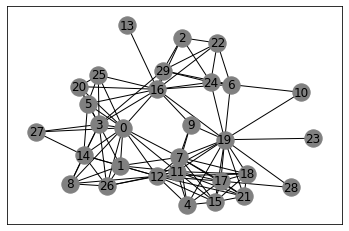

Population 500, fitness function: -12.0
lines with X stops: Counter({1: 170, 2: 29, 3: 1})


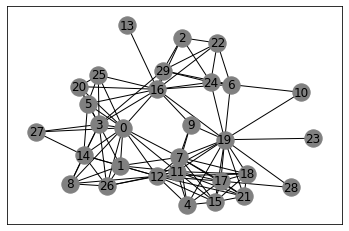

Population 600, fitness function: -12.0
lines with X stops: Counter({1: 171, 2: 27, 3: 2})


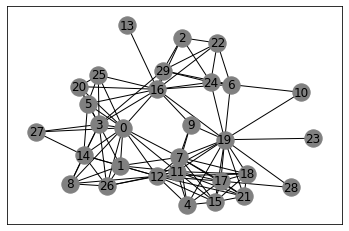

Population 700, fitness function: -12.0
lines with X stops: Counter({1: 180, 2: 19, 3: 1})


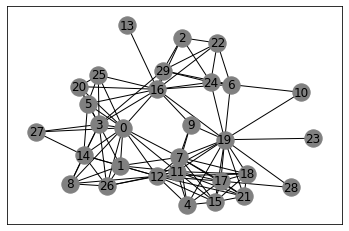

Population 800, fitness function: -12.0
lines with X stops: Counter({1: 173, 2: 26, 3: 1})


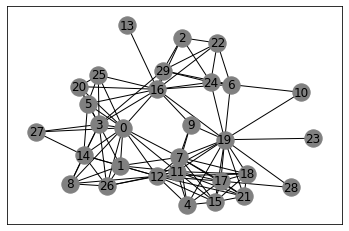

Population 900, fitness function: -12.0
lines with X stops: Counter({1: 175, 2: 24, 3: 1})


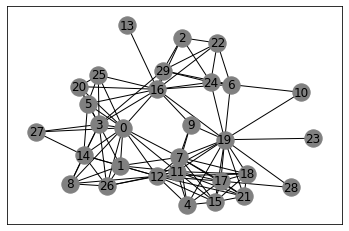

KeyboardInterrupt: 

In [11]:
random.seed(SEED)
run_simulation(show=True)